In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import os
import tarfile
import urllib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [2]:
data = pd.read_csv("jewelry.csv")

In [3]:
data.head()

,PurchaseDateTime,OrderID,ProductID,Quantity,CategoryID,Categoryalias,BrandID,PriceUSD,UserID,Gender,Color,Metal,Gem
0,2018-12-01 11:40:29 UTC,1.924720e+18,1.842200e+18,1,1.806830e+18,jewelry.earring,0.0,561.51,1.515920e+18,NaN,red,gold,diamond
1,2018-12-01 17:38:31 UTC,1.924900e+18,1.806830e+18,1,1.806830e+18,NaN,NaN,212.14,1.515920e+18,NaN,yellow,gold,NaN
2,2018-12-02 13:53:42 UTC,1.925510e+18,1.842210e+18,1,1.806830e+18,jewelry.pendant,1.0,54.66,1.515920e+18,f,white,gold,sapphire
3,2018-12-02 17:44:02 UTC,1.925630e+18,1.835570e+18,1,1.806830e+18,jewelry.pendant,0.0,88.90,1.515920e+18,f,red,gold,diamond
4,2018-12-02 21:30:19 UTC,1.925740e+18,1.873940e+18,1,1.806830e+18,jewelry.necklace,0.0,417.67,1.515920e+18,NaN,red,gold,amethyst


# Data Preparation and Cleaning

In [4]:
null_values = data.isnull().sum()
null_values 

PurchaseDateTime        0
OrderID                 0
ProductID               0
Quantity                0
CategoryID           5352
Categoryalias        9933
BrandID              4785
PriceUSD             5352
UserID               5352
Gender              48168
Color                7660
Metal                5462
Gem                 34058
dtype: int64

In [5]:
new_df = data[data['PriceUSD'].notna() & data['UserID'].notna()]

In [6]:
new_df.Gender.fillna('f', inplace=True)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90559 entries, 0 to 95910
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PurchaseDateTime  90559 non-null  object 
 1   OrderID           90559 non-null  float64
 2   ProductID         90559 non-null  float64
 3   Quantity          90559 non-null  int64  
 4   CategoryID        90559 non-null  float64
 5   Categoryalias     80626 non-null  object 
 6   BrandID           85774 non-null  float64
 7   PriceUSD          90559 non-null  float64
 8   UserID            90559 non-null  float64
 9   Gender            90559 non-null  object 
 10  Color             88251 non-null  object 
 11  Metal             90449 non-null  object 
 12  Gem               61853 non-null  object 
dtypes: float64(6), int64(1), object(6)
memory usage: 9.7+ MB


C:\Users\USER\AppData\Local\Temp\ipykernel_16724\3691910575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.Gender.fillna('f', inplace=True)


In [7]:
null_values = new_df.isnull().sum()
null_values 

PurchaseDateTime        0
OrderID                 0
ProductID               0
Quantity                0
CategoryID              0
Categoryalias        9933
BrandID              4785
PriceUSD                0
UserID                  0
Gender                  0
Color                2308
Metal                 110
Gem                 28706
dtype: int64

In [8]:
#Drop quantity since it's always 1
data.drop('Quantity',axis=1, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95911 entries, 0 to 95910
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PurchaseDateTime  95911 non-null  object 
 1   OrderID           95911 non-null  float64
 2   ProductID         95911 non-null  float64
 3   CategoryID        90559 non-null  float64
 4   Categoryalias     85978 non-null  object 
 5   BrandID           91126 non-null  float64
 6   PriceUSD          90559 non-null  float64
 7   UserID            90559 non-null  float64
 8   Gender            47743 non-null  object 
 9   Color             88251 non-null  object 
 10  Metal             90449 non-null  object 
 11  Gem               61853 non-null  object 
dtypes: float64(6), object(6)
memory usage: 8.8+ MB


In [9]:
new_df.Categoryalias.fillna('other', inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_16724\21850970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.Categoryalias.fillna('other', inplace=True)


In [10]:
new_df.Categoryalias.value_counts()

jewelry.earring       29052
jewelry.ring          28300
jewelry.pendant       13088
other                  9933
jewelry.bracelet       6188
jewelry.necklace       2361
jewelry.brooch         1288
jewelry.souvenir        170
electronics.clocks      167
jewelry.stud             12
Name: Categoryalias, dtype: int64

In [11]:
new_df['BrandID'].fillna('-1',inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_16724\741898642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['BrandID'].fillna('-1',inplace=True)


In [12]:
new_df['Gem'].unique()

array(['diamond', nan, 'sapphire', 'amethyst', 'fianit', 'pearl',
       'quartz', 'topaz', 'garnet', 'quartz_smoky', 'ruby', 'agate',
       'mix', 'citrine', 'emerald', 'amber', 'chrysolite', 'chrysoprase',
       'nanocrystal', 'turquoise', 'sitall', 'corundum_synthetic',
       'coral', 'onyx', 'nacre', 'spinel', 'tourmaline',
       'emerald_geothermal', 'garnet_synthetic', 'rhodolite',
       'sapphire_geothermal'], dtype=object)

In [13]:
for i in ('Color','Metal','Gem'):
  if i == 'Color':
    new_df[i].fillna('unknown-color',inplace=True)
  else:
    new_df[i].fillna('unknown',inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_16724\1752074605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[i].fillna('unknown-color',inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_16724\1752074605.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[i].fillna('unknown',inplace=True)


In [14]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90559 entries, 0 to 95910
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PurchaseDateTime  90559 non-null  object 
 1   OrderID           90559 non-null  float64
 2   ProductID         90559 non-null  float64
 3   Quantity          90559 non-null  int64  
 4   CategoryID        90559 non-null  float64
 5   Categoryalias     90559 non-null  object 
 6   BrandID           90559 non-null  object 
 7   PriceUSD          90559 non-null  float64
 8   UserID            90559 non-null  float64
 9   Gender            90559 non-null  object 
 10  Color             90559 non-null  object 
 11  Metal             90559 non-null  object 
 12  Gem               90559 non-null  object 
dtypes: float64(5), int64(1), object(7)
memory usage: 9.7+ MB


Data has been cleaned and ready for Exploratory Data Analysis

# Exploratory Data Analysis

In [15]:
corr_matrix = new_df.corr() # computes the standard correlation coefficient (Pearson’s r) between every pair of attributes
corr_matrix

,OrderID,ProductID,Quantity,CategoryID,PriceUSD,UserID
OrderID,1.000000,-0.064519,NaN,-0.028964,0.036963,0.126277
ProductID,-0.064519,1.000000,NaN,0.104208,-0.041196,0.007728
Quantity,NaN,NaN,NaN,NaN,NaN,NaN
CategoryID,-0.028964,0.104208,NaN,1.000000,0.008955,-0.005832
PriceUSD,0.036963,-0.041196,NaN,0.008955,1.000000,0.002302
UserID,0.126277,0.007728,NaN,-0.005832,0.002302,1.000000


In [16]:
numerical_columns = ['PriceUSD', 'Quantity']
numerical_data = new_df[numerical_columns]

# Calculate descriptive statistics
descriptive_stats = numerical_data.describe()
print(descriptive_stats)

           PriceUSD  Quantity
count  90559.000000   90559.0
mean     362.215217       1.0
std      444.155706       0.0
min        0.990000       1.0
25%      145.620000       1.0
50%      258.770000       1.0
75%      431.370000       1.0
max    34448.600000       1.0


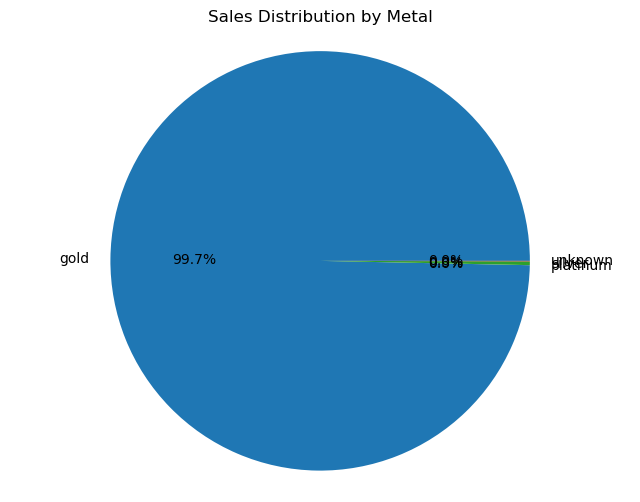

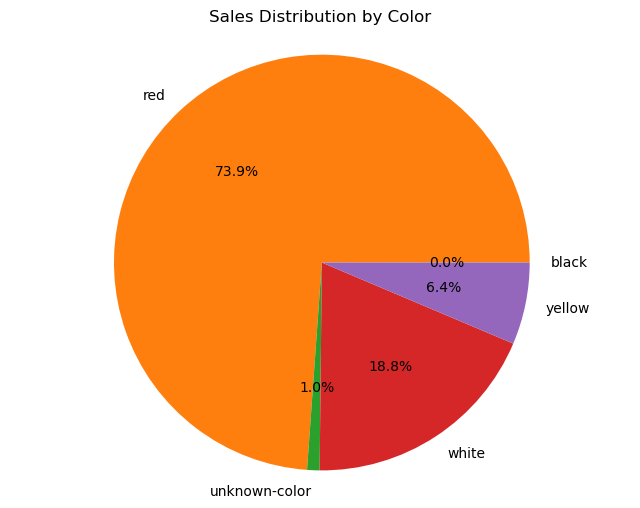

In [17]:
# Aggregate the data based on gem, metal, and color
sales_by_gem = new_df.groupby('Gem')['PriceUSD'].sum()
sales_by_metal = new_df.groupby('Metal')['PriceUSD'].sum()
sales_by_color = new_df.groupby('Color')['PriceUSD'].sum()


# Create a pie chart for metal sales
plt.figure(figsize=(8, 6))
plt.pie(sales_by_metal, labels=sales_by_metal.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Metal')
plt.axis('equal')
plt.show()

# Create a pie chart for color sales
plt.figure(figsize=(8, 6))
plt.pie(sales_by_color, labels=sales_by_color.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Color')
plt.axis('equal')
plt.show()

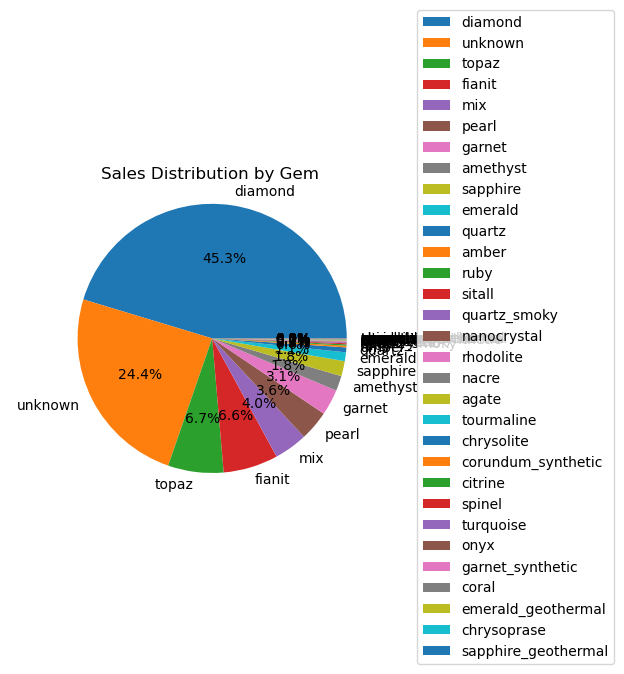

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate the data based on gem
sales_by_gem = new_df.groupby('Gem')['PriceUSD'].sum()

# Sort the sales values in descending order
sales_by_gem = sales_by_gem.sort_values(ascending=False)

# Create a pie chart for gem sales with adjusted labels
plt.figure(figsize=(8, 6))
plt.pie(sales_by_gem, labels=sales_by_gem.index, autopct='%1.1f%%')

# Add additional settings for better label readability
plt.title('Sales Distribution by Gem')
plt.axis('equal')

# Adjust label positions to avoid overlapping
plt.gca().set_position([0.1, 0.1, 0.5, 0.5])
plt.gca().set_aspect('equal')
plt.gca().legend(sales_by_gem.index, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [19]:
# Calculate the count of each Brand ID
brand_counts = new_df['BrandID'].value_counts()

# Sort the Brand ID counts in descending order
brand_counts_sorted = brand_counts.sort_values(ascending=False)

# Display the sorted Brand ID counts
print(brand_counts_sorted)

0.0    44600
1.0    32022
2.0     8966
-1      4785
4.0       65
3.0       58
6.0       56
5.0        7
Name: BrandID, dtype: int64


In [20]:
# Group the data by Brand ID and calculate the sum of PriceUSD for each group
brand_sum_price = new_df.groupby('BrandID')['PriceUSD'].sum()

# Describe the data for each Brand ID
brand_descriptions = new_df.groupby('BrandID')['PriceUSD'].describe()

# Print the summed PriceUSD values for each Brand ID
print(brand_sum_price)

# Print the description of PriceUSD for each Brand ID
print(brand_descriptions)

BrandID
0.0    15598221.68
1.0    12564192.05
2.0     2959659.90
3.0        7178.94
4.0        5374.61
5.0        1077.50
6.0       22916.81
-1      1643226.39
Name: PriceUSD, dtype: float64
           count        mean         std     min     25%      50%       75%  \
BrandID                                                                       
0.0      44600.0  349.735912  428.019601   10.27  164.25  259.970  403.9700   
1.0      32022.0  392.361253  462.087268    2.88  138.22  260.140  471.0400   
2.0       8966.0  330.098137  349.165369    7.53  116.30  252.050  431.3700   
3.0         58.0  123.774828   87.829849    2.60   29.29  129.275  185.5725   
4.0         65.0   82.686308   86.157343    1.03    8.90   25.340  146.8500   
5.0          7.0  153.928571   45.013554  103.97  120.55  152.770  176.5300   
6.0         56.0  409.228750  228.121188   78.89  255.78  306.850  719.1800   
-1        4785.0  343.411994  596.877347    0.99  136.85  239.590  438.0300   

              max 

0.0    44600
1.0    32022
2.0     8966
-1      4785
4.0       65
3.0       58
6.0       56
5.0        7
Name: BrandID, dtype: int64


<AxesSubplot:xlabel='count', ylabel='BrandID'>

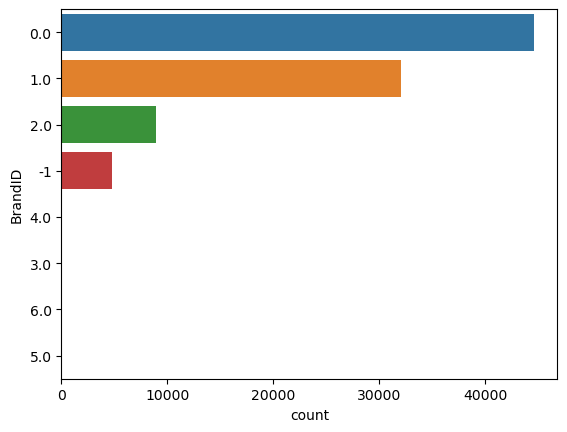

In [21]:
print(new_df.BrandID.value_counts())
sns.countplot(data = new_df, y = 'BrandID', order = new_df['BrandID'].value_counts().index)

<AxesSubplot:xlabel='count', ylabel='Categoryalias'>

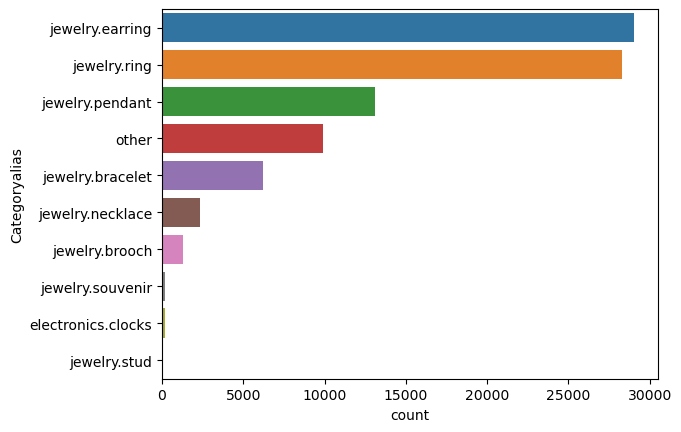

In [22]:
sns.countplot(data = new_df, y = 'Categoryalias', order = new_df['Categoryalias'].value_counts().index)

<AxesSubplot:xlabel='BrandID', ylabel='count'>

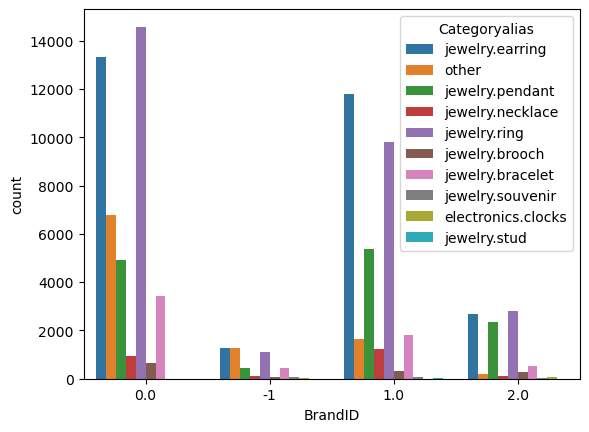

In [23]:
sns.countplot(x ='BrandID', hue = "Categoryalias", data = new_df[new_df['BrandID'].astype(int)<= 2])


# Sales forecasting

In [24]:
new_df['PurchaseDateTime'] = new_df.PurchaseDateTime.apply(lambda x : x[:10])
new_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_16724\3943212875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['PurchaseDateTime'] = new_df.PurchaseDateTime.apply(lambda x : x[:10])


,PurchaseDateTime,OrderID,ProductID,Quantity,CategoryID,Categoryalias,BrandID,PriceUSD,UserID,Gender,Color,Metal,Gem
0,2018-12-01,1.924720e+18,1.842200e+18,1,1.806830e+18,jewelry.earring,0.0,561.51,1.515920e+18,f,red,gold,diamond
1,2018-12-01,1.924900e+18,1.806830e+18,1,1.806830e+18,other,-1,212.14,1.515920e+18,f,yellow,gold,unknown
2,2018-12-02,1.925510e+18,1.842210e+18,1,1.806830e+18,jewelry.pendant,1.0,54.66,1.515920e+18,f,white,gold,sapphire
3,2018-12-02,1.925630e+18,1.835570e+18,1,1.806830e+18,jewelry.pendant,0.0,88.90,1.515920e+18,f,red,gold,diamond
4,2018-12-02,1.925740e+18,1.873940e+18,1,1.806830e+18,jewelry.necklace,0.0,417.67,1.515920e+18,f,red,gold,amethyst


In [25]:
from datetime import datetime

new_df['PurchaseDateTime'] = new_df['PurchaseDateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90559 entries, 0 to 95910
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   PurchaseDateTime  90559 non-null  datetime64[ns]
 1   OrderID           90559 non-null  float64       
 2   ProductID         90559 non-null  float64       
 3   Quantity          90559 non-null  int64         
 4   CategoryID        90559 non-null  float64       
 5   Categoryalias     90559 non-null  object        
 6   BrandID           90559 non-null  object        
 7   PriceUSD          90559 non-null  float64       
 8   UserID            90559 non-null  float64       
 9   Gender            90559 non-null  object        
 10  Color             90559 non-null  object        
 11  Metal             90559 non-null  object        
 12  Gem               90559 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(6)
memory usage: 9.7+ MB


C:\Users\USER\AppData\Local\Temp\ipykernel_16724\558761188.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['PurchaseDateTime'] = new_df['PurchaseDateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [26]:
sales_df =  pd.pivot_table(new_df, 
                 index= 'PurchaseDateTime' ,
                 values= 'PriceUSD'  ,
                 aggfunc= 'sum' ).reset_index()

sales_df.head()

,PurchaseDateTime,PriceUSD
0,2018-12-01,773.65
1,2018-12-02,897.47
2,2018-12-03,978.85
3,2018-12-04,3486.05
4,2018-12-05,1246.58


In [27]:
sales_df.sort_values('PurchaseDateTime',inplace=True)

# Sales history

In [28]:
# sns.regplot cant read date type in x so ....
sales_df['Time'] = np.arange(len(sales_df.index))

C:\Users\USER\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


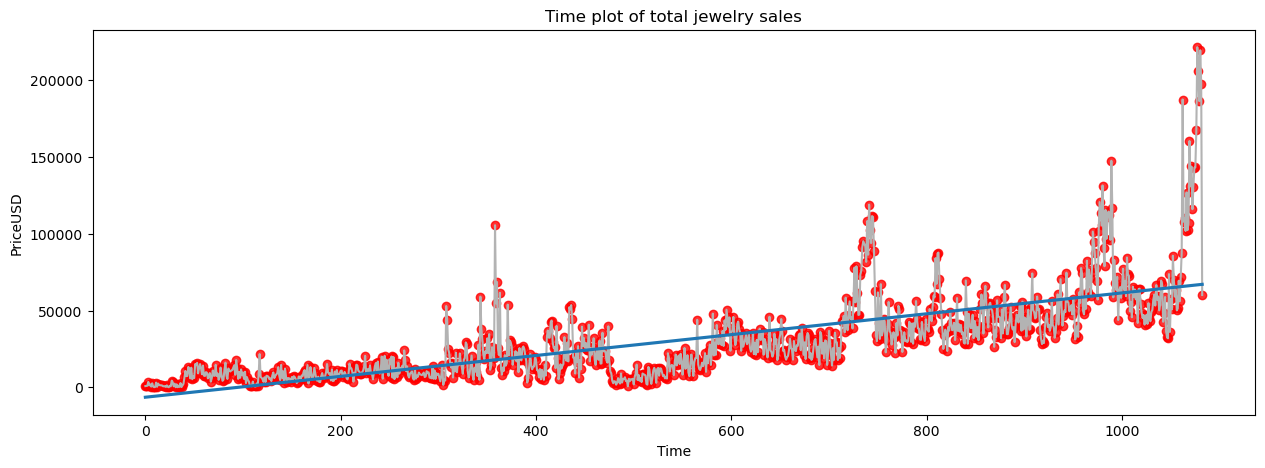

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(sales_df['Time'], sales_df["PriceUSD"],  color='0.7')
ax = sns.regplot(sales_df['Time'], sales_df["PriceUSD"],  ci=None, scatter_kws=dict(color='red'))
ax.set_title('Time plot of total jewelry sales');

In [30]:
print(f'Total number of days in sales_df: {sales_df.Time.max()} days')

Total number of days in sales_df: 1082 days


In [31]:
display(sales_df.head())
display(sales_df.tail())

,PurchaseDateTime,PriceUSD,Time
0,2018-12-01,773.65,0
1,2018-12-02,897.47,1
2,2018-12-03,978.85,2
3,2018-12-04,3486.05,3
4,2018-12-05,1246.58,4


,PurchaseDateTime,PriceUSD,Time
1078,2021-11-27,206071.70,1078
1079,2021-11-28,186474.59,1079
1080,2021-11-29,219555.01,1080
1081,2021-11-30,197417.90,1081
1082,2021-12-01,60113.20,1082


# Using Train-Test to predict sales numbers

In [32]:
sales_df.drop('Time',axis=1,inplace=True)

In [33]:
# Code reference: https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [34]:
window = 30
lag = 60
series = series_to_supervised(sales_df.drop('PurchaseDateTime', axis=1), window=window, lag=lag)
series.head()

,PriceUSD(t-30),PriceUSD(t-29),PriceUSD(t-28),PriceUSD(t-27),PriceUSD(t-26),PriceUSD(t-25),PriceUSD(t-24),PriceUSD(t-23),PriceUSD(t-22),PriceUSD(t-21),...,PriceUSD(t-8),PriceUSD(t-7),PriceUSD(t-6),PriceUSD(t-5),PriceUSD(t-4),PriceUSD(t-3),PriceUSD(t-2),PriceUSD(t-1),PriceUSD(t),PriceUSD(t+60)
30,773.65,897.47,978.85,3486.05,1246.58,1922.62,442.60,2589.26,458.07,68.36,...,1234.01,266.99,45.12,948.84,616.30,4318.76,3234.17,642.99,2355.89,12764.49
31,897.47,978.85,3486.05,1246.58,1922.62,442.60,2589.26,458.07,68.36,212.14,...,266.99,45.12,948.84,616.30,4318.76,3234.17,642.99,2355.89,42.31,14353.13
32,978.85,3486.05,1246.58,1922.62,442.60,2589.26,458.07,68.36,212.14,3064.28,...,45.12,948.84,616.30,4318.76,3234.17,642.99,2355.89,42.31,1909.46,8185.48
33,3486.05,1246.58,1922.62,442.60,2589.26,458.07,68.36,212.14,3064.28,313.43,...,948.84,616.30,4318.76,3234.17,642.99,2355.89,42.31,1909.46,51.92,17748.04
34,1246.58,1922.62,442.60,2589.26,458.07,68.36,212.14,3064.28,313.43,2443.00,...,616.30,4318.76,3234.17,642.99,2355.89,42.31,1909.46,51.92,1045.02,12493.57


## Data split 

In [35]:
from sklearn.model_selection import train_test_split

lag_size= lag

# Label
labels_col = 'PriceUSD(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)


X_train, X_test, Y_train, Y_test = train_test_split(series, labels.values, test_size=0.2, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
print('Test set shape', X_test.shape)
X_train.head()

Train set shape (476, 31)
Validation set shape (318, 31)
Test set shape (199, 31)


,PriceUSD(t-30),PriceUSD(t-29),PriceUSD(t-28),PriceUSD(t-27),PriceUSD(t-26),PriceUSD(t-25),PriceUSD(t-24),PriceUSD(t-23),PriceUSD(t-22),PriceUSD(t-21),...,PriceUSD(t-9),PriceUSD(t-8),PriceUSD(t-7),PriceUSD(t-6),PriceUSD(t-5),PriceUSD(t-4),PriceUSD(t-3),PriceUSD(t-2),PriceUSD(t-1),PriceUSD(t)
815,41558.62,28410.53,41806.85,39412.43,56162.33,44658.92,38351.92,38208.81,31200.34,30898.30,...,52621.30,59787.40,58571.98,84109.31,67384.50,87114.52,87750.93,70532.95,58081.88,47946.11
629,23822.30,35982.08,36959.99,45847.13,33602.10,27427.05,30436.61,41152.21,42834.54,37652.99,...,23223.12,25539.97,35169.58,21575.33,29030.60,21246.71,30898.09,22824.59,33465.90,38132.83
197,2465.58,6938.58,13159.55,8249.61,5014.07,7053.64,12646.07,9001.28,5607.48,4217.72,...,8665.36,9077.70,4469.33,11540.12,4045.76,4356.33,10229.27,5426.08,11240.78,7716.25
564,5673.86,22142.53,19359.24,10447.35,13620.39,14574.96,13923.72,7876.33,16523.91,21314.56,...,20918.57,9665.23,7209.68,15748.01,21369.42,16209.65,7377.27,16286.23,18960.71,19099.50
51,228.73,1234.01,266.99,45.12,948.84,616.30,4318.76,3234.17,642.99,2355.89,...,7251.81,7364.79,13222.37,11677.82,5802.28,12750.76,5232.85,7142.98,6002.55,15081.57


In [36]:
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [37]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)
print('Validation set shape', X_test_series.shape)

Train set shape (476, 31, 1)
Validation set shape (318, 31, 1)
Validation set shape (199, 31, 1)


In [38]:
pd.DataFrame(X_valid).head(3)

,PriceUSD(t-30),PriceUSD(t-29),PriceUSD(t-28),PriceUSD(t-27),PriceUSD(t-26),PriceUSD(t-25),PriceUSD(t-24),PriceUSD(t-23),PriceUSD(t-22),PriceUSD(t-21),...,PriceUSD(t-9),PriceUSD(t-8),PriceUSD(t-7),PriceUSD(t-6),PriceUSD(t-5),PriceUSD(t-4),PriceUSD(t-3),PriceUSD(t-2),PriceUSD(t-1),PriceUSD(t)
194,4610.59,9428.83,14496.44,2465.58,6938.58,13159.55,8249.61,5014.07,7053.64,12646.07,...,9692.96,15112.52,9859.27,8665.36,9077.70,4469.33,11540.12,4045.76,4356.33,10229.27
610,24114.55,47956.47,20734.53,29053.79,21117.25,40586.51,28532.89,28065.77,31925.34,28368.23,...,36959.99,45847.13,33602.10,27427.05,30436.61,41152.21,42834.54,37652.99,35512.78,23751.10
687,19583.59,20465.97,24501.21,31472.21,25540.85,24641.04,18003.41,30148.61,25386.44,23518.49,...,35369.95,33891.31,19158.13,22322.18,17815.32,19397.82,25410.44,30309.50,31418.69,25091.60


## LSTM Model

In [39]:
epochs = 200
batch = 65
lr = 0.0005
adam = tf.keras.optimizers.Adamax()

In [40]:
from tensorflow.keras.layers import Dropout

model_lstm = Sequential()
model_lstm.add(LSTM(165,activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(56))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer=adam)
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 165)               110220    
                                                                 
 dropout (Dropout)           (None, 165)               0         
                                                                 
 dense (Dense)               (None, 56)                9296      
                                                                 
 dropout_1 (Dropout)         (None, 56)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 57        
                                                                 
Total params: 119,573
Trainable params: 119,573
Non-trainable params: 0
_________________________________________________________________


## Train model

In [41]:
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2, callbacks=[callback])

Epoch 1/200
15/15 - 2s - loss: 40124.6328 - val_loss: 29138.2734 - 2s/epoch - 101ms/step
Epoch 2/200
15/15 - 0s - loss: 34944.4258 - val_loss: 24291.7148 - 268ms/epoch - 18ms/step
Epoch 3/200
15/15 - 0s - loss: 35406.0039 - val_loss: 21836.0625 - 282ms/epoch - 19ms/step
Epoch 4/200
15/15 - 0s - loss: 32551.5234 - val_loss: 20980.2871 - 277ms/epoch - 18ms/step
Epoch 5/200
15/15 - 0s - loss: 26786.5859 - val_loss: 19438.8750 - 274ms/epoch - 18ms/step
Epoch 6/200
15/15 - 0s - loss: 26901.3145 - val_loss: 18675.2188 - 274ms/epoch - 18ms/step
Epoch 7/200
15/15 - 0s - loss: 23125.9492 - val_loss: 18263.1172 - 281ms/epoch - 19ms/step
Epoch 8/200
15/15 - 0s - loss: 23200.9961 - val_loss: 18822.2773 - 282ms/epoch - 19ms/step
Epoch 9/200
15/15 - 0s - loss: 25134.2246 - val_loss: 17549.1973 - 287ms/epoch - 19ms/step
Epoch 10/200
15/15 - 0s - loss: 24387.2285 - val_loss: 18272.2266 - 269ms/epoch - 18ms/step
Epoch 11/200
15/15 - 0s - loss: 24280.1289 - val_loss: 18155.1367 - 266ms/epoch - 18ms/step

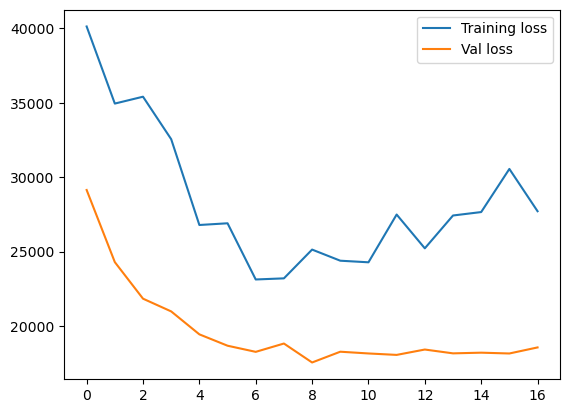

In [42]:
plt.plot(lstm_history.history['loss'], label="Training loss")
plt.plot(lstm_history.history['val_loss'], label="Val loss")
plt.legend()

In [43]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_lstm.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

10/10 [==============================] - 0s 5ms/step
Train rmse: 25518.41182638579
Validation rmse: 28883.01925424053


In [44]:
length = len(lstm_valid_pred) 

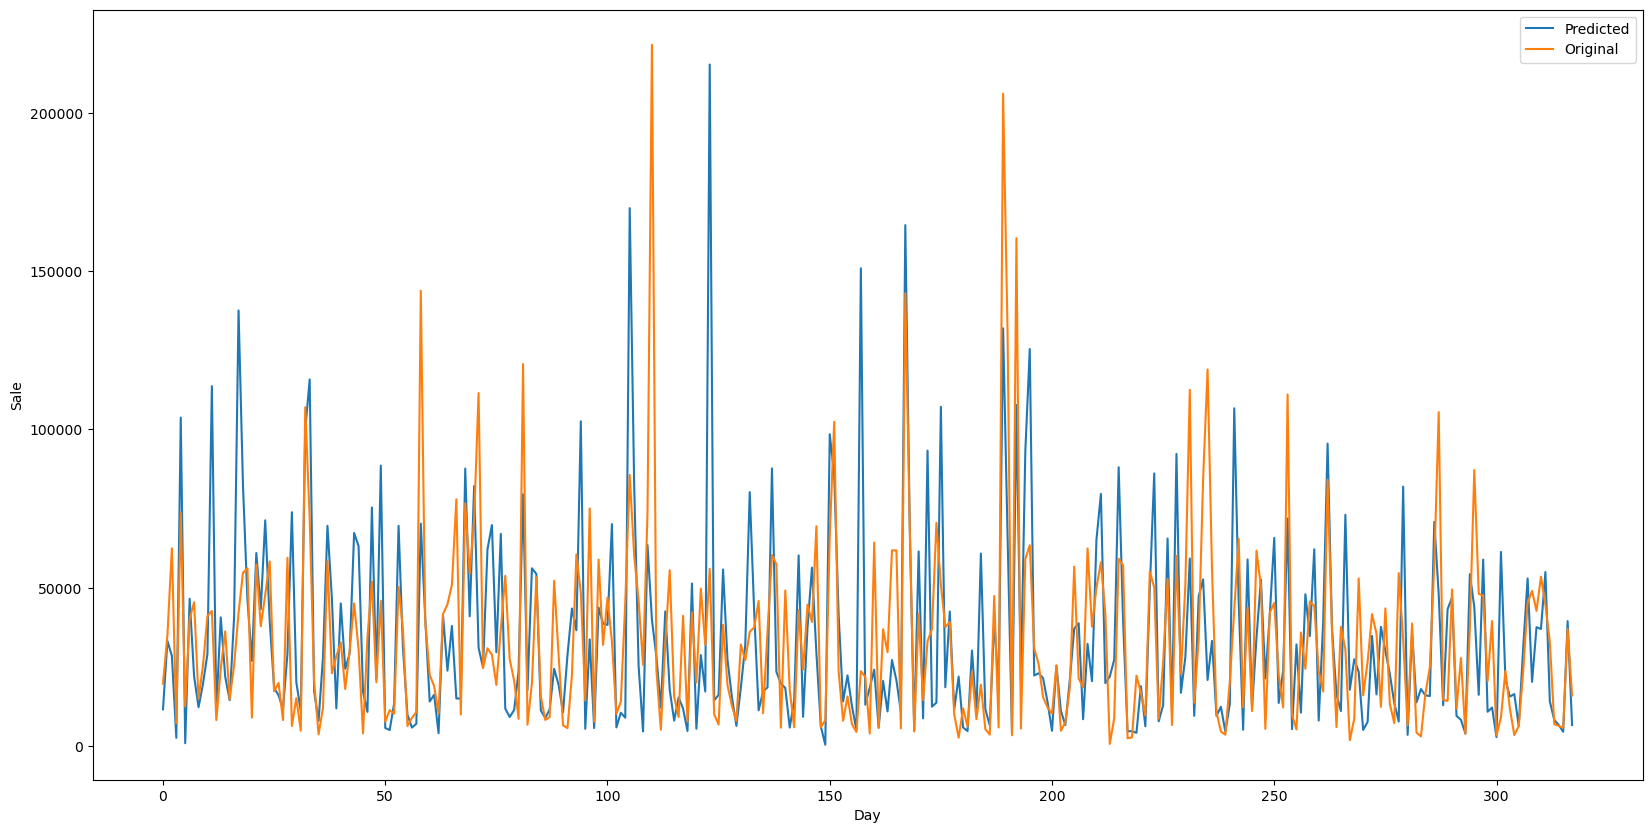

In [45]:
# data to be plotted
x = np.arange(0, length)
y1 = lstm_valid_pred[:length]
y2 = Y_valid[:length]

plt.figure(figsize=(20, 10))

# plotting
plt.xlabel("Day")
plt.ylabel("Sale")
plt.plot(x, y1.reshape(-1), label = "Predicted")
plt.plot(x, y2.reshape(-1), label = "Original")
plt.legend()
plt.show()

## Test model

In [46]:
lstm_test_pred = model_lstm.predict(X_test_series)
print('Test rmse:', np.sqrt(mean_squared_error(Y_test, lstm_test_pred)))

7/7 [==============================] - 0s 5ms/step
Test rmse: 27253.667298386612


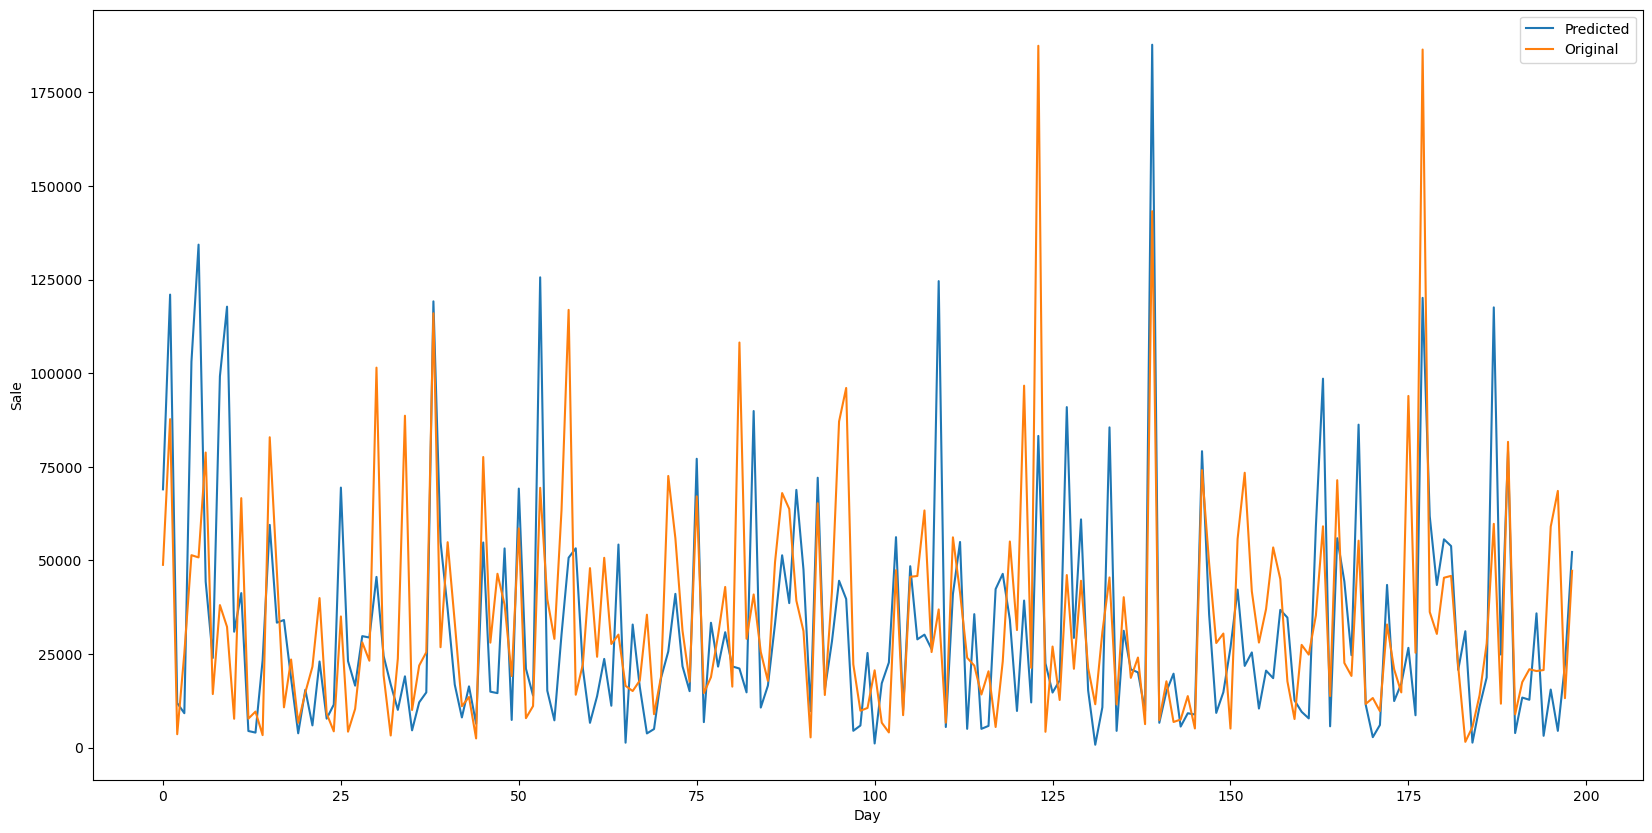

In [47]:
length_test = len(lstm_test_pred) 

x = np.arange(0, length_test)
y1 = lstm_test_pred[:length_test]
y2 = Y_test[:length_test]

plt.figure(figsize=(20, 10))

plt.xlabel("Day")
plt.ylabel("Sale")
plt.plot(x, y1.reshape(-1), label = "Predicted")
plt.plot(x, y2.reshape(-1), label = "Original")
plt.legend()
plt.show()

In [49]:
mape = np.mean(np.abs((y2 - y1) / y2)) * 100
percentage_error = np.mean((y2 - y1) / y2) * 100

print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape))
print("Percentage Error: {:.2f}%".format(percentage_error))

Mean Absolute Percentage Error (MAPE): 166.78%
Percentage Error: -104.32%
